# CNN Model for Binary Classification on TON_IoT Network Data

This notebook implements a Convolutional Neural Network (CNN) to classify network traffic data as benign (0) or malicious (1).

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))

2.9.1+cu130
True NVIDIA GeForce RTX 5060


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


Using device: cuda
CUDA device: NVIDIA GeForce RTX 5060


## Load and Explore the Data

In [2]:
# Load the dataset
df = pd.read_csv('train_test_network.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nLabel distribution:")
print(df['label'].value_counts())

Dataset shape: (211043, 44)

First few rows:
          src_ip  src_port         dst_ip  dst_port proto service    duration  \
0   192.168.1.37      4444  192.168.1.193     49178   tcp       -  290.371539   
1  192.168.1.193     49180   192.168.1.37      8080   tcp       -    0.000102   
2  192.168.1.193     49180   192.168.1.37      8080   tcp       -    0.000148   
3  192.168.1.193     49180   192.168.1.37      8080   tcp       -    0.000113   
4  192.168.1.193     49180   192.168.1.37      8080   tcp       -    0.000130   

   src_bytes  dst_bytes conn_state  ...  http_response_body_len  \
0     101568       2592        OTH  ...                       0   
1          0          0        REJ  ...                       0   
2          0          0        REJ  ...                       0   
3          0          0        REJ  ...                       0   
4          0          0        REJ  ...                       0   

   http_status_code  http_user_agent  http_orig_mime_types  \
0  

## Data Preprocessing

In [3]:
# Separate features and labels
X = df.drop(['label', 'type'], axis=1)
y = df['label']

# Handle categorical columns - encode them
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"Categorical columns: {list(categorical_cols)}")

# Create label encoders for categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = X[col].fillna('missing')  # Fill NaN with 'missing'
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Handle missing values in numerical columns
numerical_cols = X.select_dtypes(include=[np.number]).columns
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].mean())

print(f"\nProcessed features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")

Categorical columns: ['src_ip', 'dst_ip', 'proto', 'service', 'conn_state', 'dns_query', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice']

Processed features shape: (211043, 42)
Labels shape: (211043,)

Feature columns: ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'ht

In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for 1D CNN (batch, channels=1, length=features)
X_train_cnn = np.expand_dims(X_train_scaled, axis=1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=1)
input_length = X_train_cnn.shape[2]

print(f"Training set shape: {X_train_cnn.shape}")
print(f"Test set shape: {X_test_cnn.shape}")
print(f"Training labels distribution:\n{pd.Series(y_train).value_counts()}")
print(f"\nTest labels distribution:\n{pd.Series(y_test).value_counts()}")


Training set shape: (168834, 1, 42)
Test set shape: (42209, 1, 42)
Training labels distribution:
label
1    128834
0     40000
Name: count, dtype: int64

Test labels distribution:
label
1    32209
0    10000
Name: count, dtype: int64


## Build CNN Model

In [5]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Train/validation split
full_train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_size = int(0.2 * len(full_train_ds))
train_size = len(full_train_ds) - val_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Define PyTorch 1D CNN model
class TonIoTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Dropout(0.4)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = TonIoTCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)


TonIoTCNN(
  (features): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): AdaptiveMaxPool1d(output_size=1)
    (14): Dropout(p=0.4, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256

## Train the Model

In [6]:
def batch_accuracy(logits, labels):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    return (preds == labels).float().mean().item()

EPOCHS = 15
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    batches = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb).squeeze()
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += batch_accuracy(logits, yb)
        batches += 1
    train_loss = running_loss / batches
    train_acc = running_acc / batches

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_batches = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb).squeeze()
            loss = criterion(logits, yb)
            val_loss += loss.item()
            val_acc += batch_accuracy(logits, yb)
            val_batches += 1
    val_loss /= max(1, val_batches)
    val_acc /= max(1, val_batches)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")

print("\nTraining completed!")


Starting training...
Epoch 01 | Train Loss 0.0470 | Val Loss 0.0128 | Train Acc 98.44% | Val Acc 99.69%
Epoch 02 | Train Loss 0.0171 | Val Loss 0.0093 | Train Acc 99.56% | Val Acc 99.83%
Epoch 03 | Train Loss 0.0142 | Val Loss 0.0074 | Train Acc 99.66% | Val Acc 99.83%
Epoch 04 | Train Loss 0.0115 | Val Loss 0.0052 | Train Acc 99.73% | Val Acc 99.90%
Epoch 05 | Train Loss 0.0105 | Val Loss 0.0050 | Train Acc 99.76% | Val Acc 99.88%
Epoch 06 | Train Loss 0.0091 | Val Loss 0.0055 | Train Acc 99.79% | Val Acc 99.88%
Epoch 07 | Train Loss 0.0082 | Val Loss 0.0032 | Train Acc 99.81% | Val Acc 99.93%
Epoch 08 | Train Loss 0.0074 | Val Loss 0.0035 | Train Acc 99.82% | Val Acc 99.92%
Epoch 09 | Train Loss 0.0070 | Val Loss 0.0034 | Train Acc 99.84% | Val Acc 99.93%
Epoch 10 | Train Loss 0.0062 | Val Loss 0.0044 | Train Acc 99.85% | Val Acc 99.92%
Epoch 11 | Train Loss 0.0062 | Val Loss 0.0029 | Train Acc 99.84% | Val Acc 99.92%
Epoch 12 | Train Loss 0.0056 | Val Loss 0.0053 | Train Acc 99.88% 

## Visualize Training History

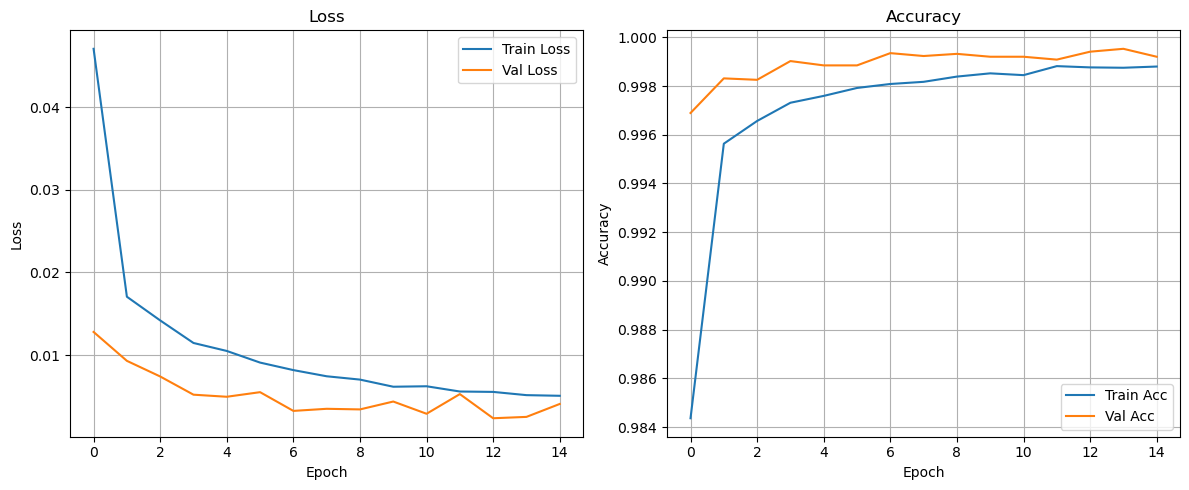

In [7]:
# Plot training history (PyTorch)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(train_loss_hist, label='Train Loss')
axes[0].plot(val_loss_hist, label='Val Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(train_acc_hist, label='Train Acc')
axes[1].plot(val_acc_hist, label='Val Acc')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Evaluate the Model

In [8]:
# Evaluate on test set
model.eval()
test_loss = 0.0
test_acc = 0.0
test_batches = 0
all_logits = []
all_labels = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb).squeeze()
        loss = criterion(logits, yb)
        test_loss += loss.item()
        test_acc += batch_accuracy(logits, yb)
        test_batches += 1
        all_logits.append(logits.cpu())
        all_labels.append(yb.cpu())

test_loss /= max(1, test_batches)
test_acc /= max(1, test_batches)
all_logits = torch.cat(all_logits)
all_labels = torch.cat(all_labels)

print(f"\n{'='*50}")
print("Test Results:")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")



Test Results:
Test Loss: 0.0029
Test Accuracy: 0.9993 (99.93%)


In [9]:
# Make predictions
probs = torch.sigmoid(all_logits).numpy()
y_pred = (probs > 0.5).astype(int).flatten()
y_true = all_labels.numpy().astype(int)

print("\nClassification Report:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=['Benign (0)', 'Malicious (1)']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Additional metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}")



Classification Report:
               precision    recall  f1-score   support

   Benign (0)       1.00      1.00      1.00     10000
Malicious (1)       1.00      1.00      1.00     32209

     accuracy                           1.00     42209
    macro avg       1.00      1.00      1.00     42209
 weighted avg       1.00      1.00      1.00     42209


Confusion Matrix:
[[ 9976    24]
 [    4 32205]]
Accuracy: 0.9993 | F1: 0.9996


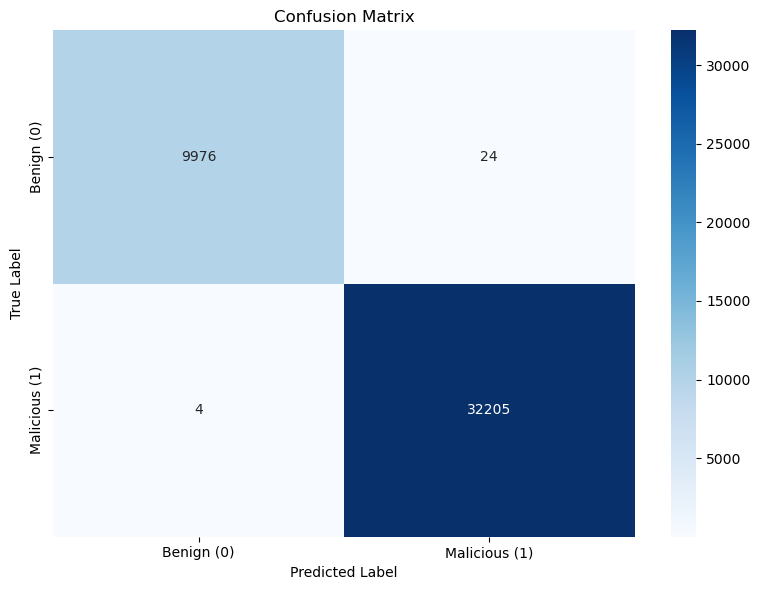

In [10]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign (0)', 'Malicious (1)'],
            yticklabels=['Benign (0)', 'Malicious (1)'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


## Save the Model

In [11]:
# Save the trained model and scaler
import pickle

torch.save(model.state_dict(), 'ton_iot_cnn_model.pt')
print("Model weights saved as 'ton_iot_cnn_model.pt'")

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved as 'scaler.pkl'")


Model weights saved as 'ton_iot_cnn_model.pt'
Scaler saved as 'scaler.pkl'
